In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [62]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc
from sqlalchemy.sql import label

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Create the inspector and check table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Display column names and data types for Measurement
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# Display column names and data types for Station
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [10]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [31]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [91]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23')

In [112]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date = dt.date(2017, 8, 23)
query_date = most_recent_date - dt.timedelta(days = 365)
print(query_date)

# Perform a query to retrieve the data and precipitation scores
last_year_precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > query_date).\
    order_by(Measurement.date).statement

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.read_sql(last_year_precip, session.bind)

precip_df.set_index('date', inplace = True)
precip_df.head(-1)

2016-08-23


,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22
...,...
2017-08-22,0.00
2017-08-22,0.50
2017-08-23,0.00


In [113]:
# Drop null values
clean_precip_df = precip_df.dropna()
clean_precip_df.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


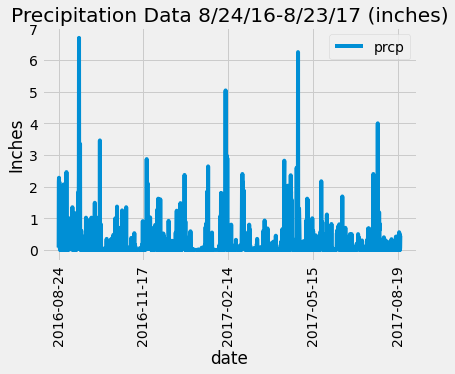

In [114]:
clean_precip_df.plot(y = 'prcp', rot = 90)
plt.title("Precipitation Data 8/24/16-8/23/17 (inches)")
plt.ylabel("Inches")
plt.show()

### Summary Statistics

In [115]:
# Use Pandas to calcualte the summary statistics for the precipitation data
clean_precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [66]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Measurement.station).group_by(Measurement.station).count()
print(f"There are {station_count} unique stations in our dataset.")

There are 9 unique stations in our dataset.


In [81]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
observation_counts = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    all()

for station in observation_counts:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [90]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_stn = 'USC00519281'

most_active_summary = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_stn).\
    all()
min_prcp = most_active_summary[0][0]
max_prcp = most_active_summary[0][1]
avg_prcp = most_active_summary[0][2]


print(f"The minimum temperature recorded at station {most_active_stn} is {min_prcp} degrees F.")
print(f"The maximum temperature recorded at station {most_active_stn} is {max_prcp} degrees F.")
print(f"The average temperature recorded at station {most_active_stn} is {avg_prcp} degrees F.")

The minimum temperature recorded at station USC00519281 is 54.0 degrees F.
The maximum temperature recorded at station USC00519281 is 85.0 degrees F.
The average temperature recorded at station USC00519281 is 71.66378066378067 degrees F.


In [92]:
# Find most recent date for most active station
date = session.query(Measurement.date).\
    filter(Measurement.station == most_active_stn).\
    order_by(Measurement.date.desc()).\
    first()
date

('2017-08-18')

In [94]:
# Create datetime object and use timedelta to get one year before
temp_query_date = dt.date(2017,8,18) - dt.timedelta(days = 365)
print(temp_query_date)

2016-08-18


In [122]:
# Query the last 12 months of temperature observation data for this station and create dataframe
last_year_temps = session.query(Measurement.tobs).\
    filter(Measurement.date > temp_query_date).\
    filter(Measurement.station == most_active_stn).statement
temps_df = pd.read_sql(last_year_temps, session.bind)
temps_df.head()

,tobs
0,79.0
1,81.0
2,79.0
3,78.0
4,77.0


<AxesSubplot:ylabel='Frequency'>

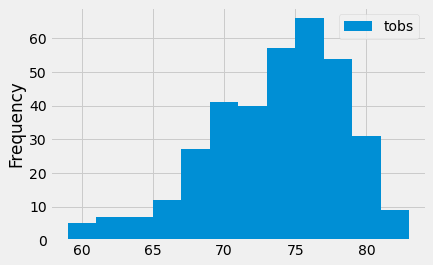

In [120]:
# Plot histogram
temps_df.plot(kind = 'hist', bins = 12)
plt.title(f"Station {most_active_stn} ")
plt.show()

# Close session

In [29]:
# Close Session
session.close()